In [2]:
%load_ext autoreload
%autoreload 2
from __future__ import print_function
from enlib import enmap
import numpy as np
from orphics import maps,io,stats,cosmology,lensing

In [80]:
width_deg = 20.
height_deg = 10.
px = 1.0
shape,wcs = maps.rect_geometry(width_deg=width_deg,height_deg=height_deg,px_res_arcmin=px)
cc = cosmology.Cosmology(lmax=6000,pickling=True,skipPower=True,dimensionless=False)
theory = cc.theory
modlmap = enmap.modlmap(shape,wcs)
lmax = modlmap.max()
ells = np.arange(0,lmax,1)
ps_cmb = theory.lCl('TT',ells).reshape((1,1,ells.size))
cmb2d = theory.lCl('TT',modlmap)





Generating theory Cls...
Loaded cached Cls from  output/clsAll_low_acc_False_6000_20180324.pkl
Loaded cached Cls from  output/clphi_low_acc_False_6000_20180324.txt


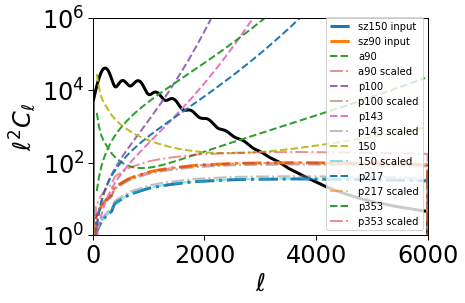

(600, 1200)
Populating covariance for  90 x 90
Populating covariance for  90 x 100
Populating covariance for  90 x 143
Populating covariance for  90 x 149
Populating covariance for  90 x 217
Populating covariance for  90 x 353
Populating covariance for  100 x 90
Populating covariance for  100 x 100
Populating covariance for  100 x 143
Populating covariance for  100 x 149
Populating covariance for  100 x 217
Populating covariance for  100 x 353
Populating covariance for  143 x 90
Populating covariance for  143 x 100
Populating covariance for  143 x 143
Populating covariance for  143 x 149
Populating covariance for  143 x 217
Populating covariance for  143 x 353
Populating covariance for  149 x 90
Populating covariance for  149 x 100
Populating covariance for  149 x 143
Populating covariance for  149 x 149
Populating covariance for  149 x 217
Populating covariance for  149 x 353
Populating covariance for  217 x 90
Populating covariance for  217 x 100
Populating covariance for  217 x 143


In [141]:


#freqs = [90,100,120,217,300]
#beams = [1.4,1.4,1.4,1.4,1.4]
#noises = [1,1,1,1,1]
#lknees = [0.,0,0,0,0]
#alphas = [1,1,1,1,1]
#labels = ['a90','p100','p143','150','p217']

labels = ['a90','p100','p143','150','p217','p353']
freqs = [90,100,143,149,217,353]
beams = [1.4*149./90.,9.66,7.27,1.4,5.01,4.86]
noises = [20.,65,43,10.,66,200]
lknees = [1000.,0,0,3000,0,0]
alphas = [-3.5,1,1,-3.5,1,1]

sz_off_factor = 10.

#lknees = [0.,0,0,0,0,0]
#alphas = [1,1,1,1,1,1]


def gnu(nu_ghz,tcmb=2.7255):
    nu = 1e9*nu_ghz
    hplanck = 6.62607e-34
    kboltzmann = 1.38065e-23 
    x = hplanck*nu/kboltzmann/tcmb
    coth = np.cosh(x/2.)/np.sinh(x/2.)
    return x*coth-4.

from szar import foregrounds as fgs
fnoises = fgs.fgNoises(cosmology.defaultConstants,ksz_file='../../szar/input/ksz_BBPS.txt',ksz_p_file='../../szar/input/ksz_p_BBPS.txt',tsz_cib_file='../../szar/input/sz_x_cib_template.dat',tsz_battaglia_template_csv="../../szar/input/sz_template_battaglia.csv",components=['tsz'],lmax=6000)

ps_sz_150 = fnoises.get_tot_fg_noise(150.,ells,components=['tsz'])
ps_sz_90 = fnoises.get_tot_fg_noise(90.,ells,components=['tsz'])


bin_edges = np.arange(50,6000,40)
binner = stats.bin2D(modlmap,bin_edges)
marray = maps.MultiArray(shape,wcs)

marray.add_gaussian_foreground("tsz",sz_off_factor*ps_sz_150.reshape((1,1,ells.size)),150.,gnu)

marray.init_flat_cmb_sim(ps_cmb)
pl = io.Plotter(yscale='log',xlabel="$\\ell$",ylabel="$\\ell^2C_{\\ell}$")
pl.add(ells,ps_cmb[0,0]*ells**2.,lw=3,color='k')
pl.add(ells,ps_sz_150*ells**2.,lw=3,ls="-.",label="sz150 input")
pl.add(ells,ps_sz_90*ells**2.,lw=3,ls="-.",label="sz90 input")

ns = []
for i,label in enumerate(labels):
    nT,nP = marray.add_array(label,freqs[i],beams[i],noises[i],lknee_T=lknees[i],alpha_T=alphas[i])
    ns.append(nT)
    cents,n1d = binner.bin(nT)
    pl.add(cents,n1d*cents**2.,lw=2,ls="--",label=label)
    pl.add(ells,ps_sz_150*ells**2.*((marray.freq_scale_func['tsz'](freqs[i])/(marray.freq_scale_func['tsz'](150.)))**2.),lw=2,alpha=0.5,ls="-.",label=label+" scaled")
pl._ax.set_xlim(0,6000)
pl._ax.set_ylim(1,1e6)
pl.legend(loc='lower right')
pl.done()

kmask = maps.mask_kspace(shape,wcs,lmin=10,lmax=6000)
print(ns[0].shape)
analytic_ilc_cov = maps.ilc_cov(modlmap,cmb2d,[1]*len(ns),freqs,ns,['tsz'],fnoises,plot=False,plot_save=None,kmask=kmask)
    



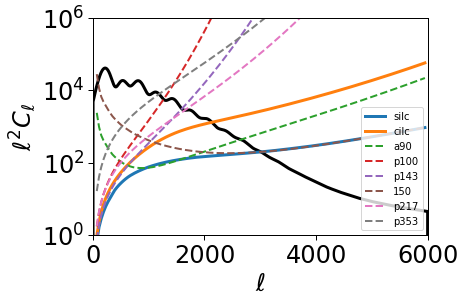

In [142]:
analytic_cinv = np.linalg.inv(analytic_ilc_cov.T).T

yresponses = gnu(np.array(freqs))
cresponses = yresponses*0.+1.

silc_noise2d = maps.silc_noise(analytic_cinv)
cilc_noise2d = maps.cilc_noise(analytic_cinv,cresponses,yresponses)
cents,snoise1d = binner.bin(silc_noise2d )
cents,cnoise1d = binner.bin(cilc_noise2d )

cents,cmb1d = binner.bin(cmb2d)


pl = io.Plotter(yscale='log',xlabel="$\\ell$",ylabel="$\\ell^2C_{\\ell}$")
pl.add(ells,ps_cmb[0,0]*ells**2.,lw=3,color='k')
pl.add(cents,(snoise1d-cmb1d) *cents**2.,lw=3,label="silc")
pl.add(cents,(cnoise1d-cmb1d) *cents**2.,lw=3,label="cilc")


for i,label in enumerate(labels):
    nT = ns[i]
    cents,n1d = binner.bin(nT)
    pl.add(cents,n1d*cents**2.,lw=2,ls="--",label=label)
pl._ax.set_xlim(0,6000)
pl._ax.set_ylim(1,1e6)
pl.legend(loc='lower right')
pl.done()

In [46]:
# Set up SZ frequency dependence


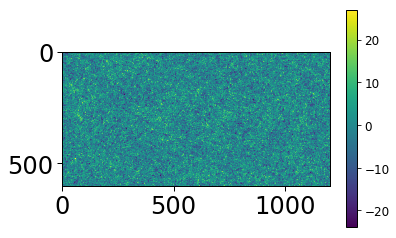

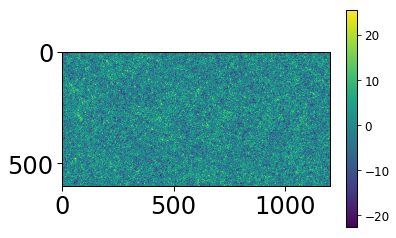

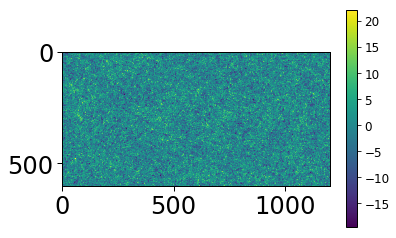

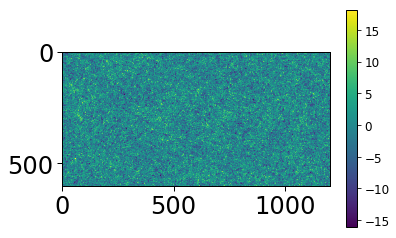

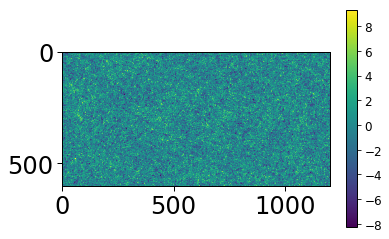

In [128]:
sky1 = marray.get_sky([],0,0,0)
sky2,fg = marray.get_sky(None,0,0,0,return_fg=True)
for j in range(sky1.shape[0]):
    io.plot_img(sky1[j]-sky2[j])

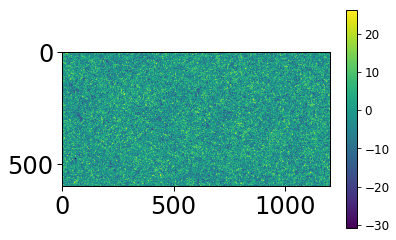

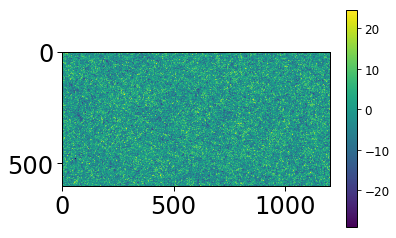

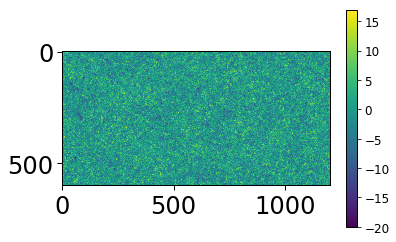

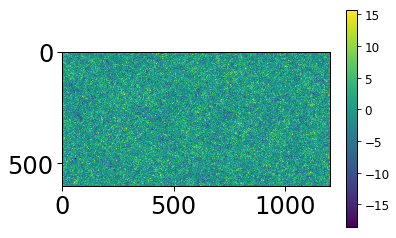

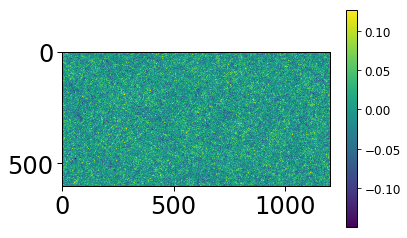

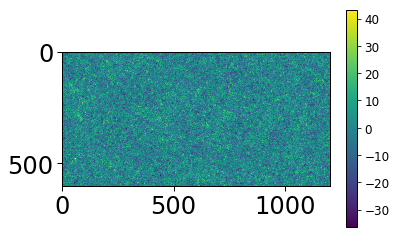

In [118]:
for j in range(sky1.shape[0]):
    io.plot_img(fg[j])

In [143]:



N = 5

st = stats.Stats()
fc = maps.FourierCalc(shape,wcs)

for i in range(N):
    sky, fg = marray.get_sky(return_fg=True)
    kmaps = marray.fft_data(sky,kmask)
    kfg = enmap.fft(fg[freqs.index(90)])
    ksilc = maps.silc(kmaps,analytic_cinv)
    kcilc = maps.cilc(kmaps,analytic_cinv,cresponses,yresponses)
    
    st.add_to_stats("silcXfg",binner.bin(fc.f2power(ksilc,kfg))[1])
    st.add_to_stats("cilcXfg",binner.bin(fc.f2power(kcilc,kfg))[1])
    
    print(i)
    
st.get_stats()
print("done!")

0
1
2
3
4
done!


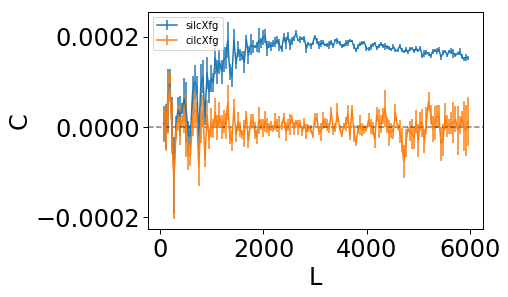

In [139]:
pl = io.Plotter(xlabel="L",ylabel="C")
for lab in ["silcXfg","cilcXfg"]:
    pl.add_err(cents,st.stats[lab]["mean"]*cents**2.,yerr=st.stats[lab]["errmean"]*cents**2.,label=lab,ls="-")
pl.legend()
pl.hline()
pl.done()